In [1]:
%matplotlib nbagg

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from libertem import api
from libertem import masks
from libertem.analysis.com import com_masks_factory, center_shifts, divergence, curl_2d, magnitude
from libertem.udf.masks import ApplyMasksUDF
from libertem.executor.inline import InlineJobExecutor
from libertem.executor.base import AsyncAdapter
from libertem.udf.base import UDFRunner

In [70]:
ctx = api.Context()
async_executor = AsyncAdapter(ctx.executor)

In [71]:
ds = ctx.load(
    "EMPAD", path=r'C:\Users\weber\Nextcloud\Projects\Open Pixelated STEM framework\Data\EMPAD/acquisition_12.xml',
    scan_size=(128,128),
)
ds._cores = 32

In [72]:
len(list(ds.get_partitions()))

32

In [73]:
def rotate(y_shift, x_shift, angle):
    sin = np.sin(np.pi/180*angle)
    cos = np.cos(np.pi/180*angle)
    return y_shift * cos + x_shift * sin, -y_shift * sin + x_shift * cos


In [74]:
ds_sig = tuple(ds.shape.sig)
cy = 64 # to be adjusted
cx = 64 / 2 # to be adjusted
r = 32  # to be adjusted

com_f = com_masks_factory(
    detector_y=ds_sig[0],
    detector_x=ds_sig[1],
    cy=cy,
    cx=cx,
    r=r*1.1,
)
adf = lambda: masks.ring(
    centerY=cy,
    centerX=cx,
    imageSizeY=ds_sig[0],
    imageSizeX=ds_sig[1],
    radius=r*2,
    radius_inner=r*1.1,
    antialiased=True
)

In [75]:
factories = com_f + [adf]

In [76]:
len(factories)

4

In [77]:
udf = ApplyMasksUDF(mask_factories=factories)

<IPython.core.display.Javascript object>


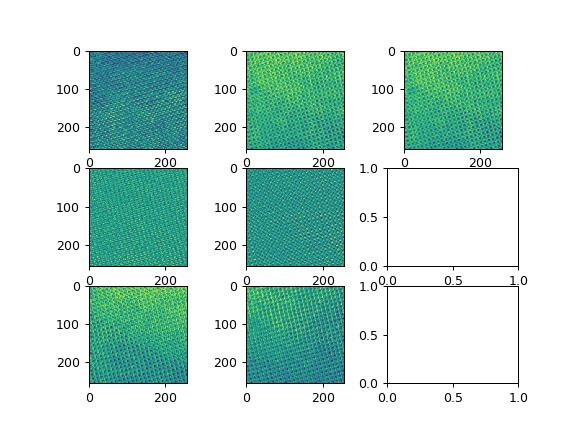

In [79]:
fig, axes= plt.subplots(3, 3)

angle = 0. # to be adjusted

im_obj = dict()
for i in range(3):
    for j in range(3):
        im_obj[(i, j)] = None

udfres_iter = UDFRunner(udf).run_for_dataset_async(dataset=ds, executor=async_executor, cancel_id="whatever")
async for udf_results in udfres_iter:
    res = udf_results['intensity'].data
    y_centers, x_centers = rotate(
        *center_shifts(res[..., 0], res[..., 1], res[..., 2], cy, cx),
        angle
    )
    
    data_items = {
        (0, 0): y_centers,
        (0, 1): x_centers,
        (0, 2): magnitude(y_centers, x_centers),
        (1, 0): divergence(y_centers, x_centers),
        (1, 1): curl_2d(y_centers, x_centers),
        (2, 0): res[..., 0], # bright field
        (2, 1): res[..., 3], # annular dark field
    }
    for key, data in data_items.items():
        if im_obj[key] is None:
            im_obj[key] = axes[key].imshow(data)
        else:
            im_obj[key].set_data(data)
        i_o = im_obj[key]
        i_o.autoscale()
        i_o.norm.vmin = np.min(data[data!=0])
        i_o.norm.vmax = np.max(max(1, np.max(data[data!=0])))
        i_o.changed()
    fig.canvas.draw()